In [1]:
"""
Find an example vanilla GDA (no timescale sep) doesnt converge 
(perhaps leaves the stabilizing set of controllers)
and stackelberg converges.  

Based on:
Exact Natural Gradient Descent for LQR control.

by J.
"""

# (initial condition)
"""

"""
%matplotlib inline
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from scipy import signal
import scipy.linalg as SLA
import scipy.io
import matplotlib
matplotlib.rcParams['text.usetex'] = True
from matplotlib.ticker import MaxNLocator

In [2]:
N = 5

# The $Q$ is chosen as some fixed matrix $+$ Gaussian random noise;
# To make our simulations consitent, I have save the data and read from file.
#######
# Q = 3 * np.diagflat([-1, -1, 1, 1, 1]) + np.random.randn(N, N) * 0.01
# Q = (Q + Q.T) / 2

Q = np.load('Q.npy')
A = 0.5 * np.identity(N)
B = np.identity(N)
B2, B1 = B[:, :2], B[:, 2:]

R = np.diagflat([1, 1, -1, -1, -1])
R2, R1 = -R[:2, :2], R[2:, 2:]

# optimal K
X = SLA.solve_discrete_are(A, B, Q, R)
K_opt = LA.inv( R + B.T @ X @ B ) @ B.T @ X @ A
L, K = K_opt[:2, :], K_opt[2:, :]
# Initial state matrix is identity
# As such, cost is equal to $trace(X)$
initial_state = np.identity( N )
cost_opt = np.trace( X @ initial_state )

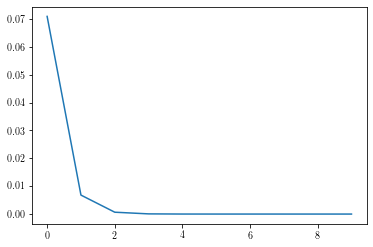

In [3]:
norm = []
P = Q
for _ in range(10):
    P = A.T@P@A-(A.T@P@B)@LA.solve(R+B.T@P@B,B.T@P@A)+Q
    norm.append(LA.norm(P-X))
P, X
plt.plot(norm)

In [4]:
print("A=",A)
print("B1=",B1)
print("B2=",B2)
print("Q=",Q)
print("R1=",R1)
print("R2=",R2)

A= [[0.5 0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0. ]
 [0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.  0.5]]
B1= [[0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
B2= [[1. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
Q= [[-3.01760074e+00 -2.81426740e-03  4.32973286e-03 -1.06481328e-02
  -6.85531223e-03]
 [-2.81426740e-03 -3.00443882e+00  8.68684314e-03  2.52575795e-04
  -3.03010149e-03]
 [ 4.32973286e-03  8.68684314e-03  2.99678507e+00 -1.12890593e-02
   3.76770625e-03]
 [-1.06481328e-02  2.52575795e-04 -1.12890593e-02  2.99982394e+00
  -4.41594781e-03]
 [-6.85531223e-03 -3.03010149e-03  3.76770625e-03 -4.41594781e-03
   3.00709409e+00]]
R1= [[-1  0  0]
 [ 0 -1  0]
 [ 0  0 -1]]
R2= [[-1  0]
 [ 0 -1]]



count=2, seed=2788441, delta=0.45: 
FOUND: left the stabilizing set (iter 9 )
sp(Acl): 0.8233136679314406 to 0.9027662308020971 to 1.0426487563392282


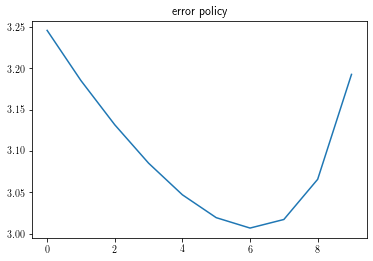

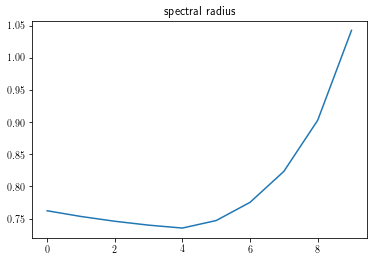

L0= [[ 0.87 -0.1  -0.23  0.   -0.19]
 [ 0.26  0.55 -0.24  0.42 -0.05]]

K0= [[ 0.21  0.33 -0.4   0.39 -0.22]
 [ 1.03  0.42 -0.59  0.49 -0.48]
 [-0.3   1.56 -0.2   0.13  0.39]]



In [5]:
###########
### CODE BLOCK A
###
### Scan for initial conditions that causes SIMGRAD to leave the stabilizing set
###
#######
from sys import stdout
np.set_printoptions(precision=2)

##### PARAMETERS
delta = 0.45 # noise 
ss_l = 0.005 # step size (L)
ss_k = 0.005 # step size (K)
# start_seed = 996998 #6056#5408
# start_seed = 1179277
# start_seed = 1474053
#start_seed = 2196281
start_seed = 2788441
MAX_ITER = 64
stable_iterations = 3
#stable_iterations = 10
count = 1
plot_freq = 50
done = False
plot = False
single_run = True # Set to False to continually run
seeds = []

for seed in range(start_seed, int(1e8)):
    failed = False
    
    np.random.seed(seed)
    L0 = L + delta*np.random.randn(*L.shape)
    K0 = K + delta*np.random.randn(*K.shape)
    Linitial = L0
    Kinitial = K0
    
    error = np.zeros((MAX_ITER))*np.nan
    error_policy = np.zeros((MAX_ITER))*np.nan
    specrad = np.zeros((MAX_ITER))*np.nan
    specrads = np.zeros((2,MAX_ITER))*np.nan
    profiles = [(K0,L0)]
    grads = []
    
    
    stdout.write('\rcount={}, seed={}, delta={}: '.format(count+1, seed, delta))
    for i in range(MAX_ITER):
        
        Acl = A-B1@K0 - B2@L0
        specrad[i] = np.max(np.abs(np.linalg.eigvals(Acl)))
        error_policy[i] = LA.norm(K0 - K, 'fro') + LA.norm(L0 - L, 'fro')
        
        if specrad[0] >= 1: 
            break
            
        # starts in stabilizing set, leaves stabilizing set after stable_iterations
        if i> stable_iterations and specrad[i]>= 1 and np.all(specrad[:i-1] < 1):
            print()
            print("FOUND: left the stabilizing set (iter", i, ")")
            print("sp(Acl):", specrad[i-2], 'to', specrad[i-1], 'to', specrad[i])
            seeds.append(seed)
            plot = True
            done = single_run #False
            break
            
        # TODO: CHECK IF THE EQUATIONS BELOW ARE CORRECT
        try:
            X0 = SLA.solve_discrete_are(A-B2 @ L0, B1, Q - L0.T @ R2 @ L0, R1)
            W0 = SLA.solve_discrete_are(A-B1 @ K0, B2, -Q - K0.T @ R1 @ K0, R2)
        except LA.LinAlgError:
            #print('Failed to solve DARE at iteration', i ,')\n', 'sp(Acl)=', specrad[i])
            break

        gd_k = 2 * ( R1 @ K0 - B1.T @ (-W0) @ (A-B1@K0 - B2@L0) )
        gd_l = 2 * ( -R2 @ L0 - B2.T @ X0 @ (A-B1@K0 - B2@L0) )
        if not len(grads):
            grads.append((gd_k, gd_l))
            

        # update
        K1 = K0 - ss_k * gd_k
        L1 = L0 + ss_l * gd_l


        L0 = L1
        K0 = K1
    
        specrad_prev = specrad
        
        error[i] = np.trace( (X - X0) @ initial_state )
        profiles.append((K0, L0))
        grads.append((gd_k, gd_l))
    else:
        count += 1
        
    if count % plot_freq == 0:
        count += 1
        plot = True
        
    if plot: 
        plt.title('error policy')
        plt.plot(error_policy)
        plt.show()
        plt.title('spectral radius')
        plt.plot(specrad)
        plt.show()
        print("L0=", Linitial)
        print()
        print("K0=", Kinitial)
        print()
        plot = False
    if done: 
        break

seed= 2788441
delta= 0.45
L0= [[ 0.87 -0.1  -0.23  0.   -0.19]
 [ 0.26  0.55 -0.24  0.42 -0.05]]


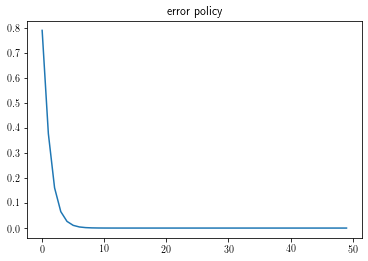

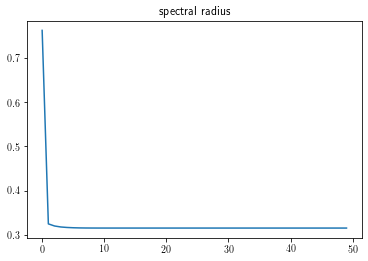

SUCCESS


In [6]:
##########################
## CODE BLOCK B
##
## Natural Gradient for L
##########################

myseed = seed
mydelta = delta
np.random.seed(myseed)
L0 = L + mydelta*np.random.randn(*L.shape)
K0 = K + mydelta*np.random.randn(*K.shape)
print("seed=",myseed)
print("delta=",mydelta)
print("L0=",L0)


X_old = X
MAX_ITER = 50
error = np.zeros((MAX_ITER))
error_policy = np.zeros((MAX_ITER))
specrad = np.zeros((MAX_ITER))
for i in range(MAX_ITER):
    Acl = A-B1@K0 - B2@L0
    specrad[i] = np.max(np.abs(np.linalg.eigvals(Acl)))
    X0 = SLA.solve_discrete_are(A-B2 @ L0, B1, Q - L0.T @ R2 @ L0, R1)
#     error[i] = LA.norm(X0-X)
    error[i] = np.trace( (X - X0) @ initial_state )
    K0 = SLA.inv(R1 + B1.T @ X0 @ B1) @ B1.T @ X0 @ (A-B2 @ L0)
    error_policy[i] = LA.norm(K0 - K, 'fro') + LA.norm(L0 - L, 'fro')
    # natural gradient
    ngd = 2 * ( -R2 @ L0 - B2.T @ X0 @ (A - B1@K0 - B2@L0) )
    # matrix $O_j$; see paper for definition
    O1 = R2 - B2.T @ X0 @ B2 + B2.T @ X0 @ B1 @ SLA.inv(R1 + B1.T @ X0 @ B1) @ B1.T @ X0 @ B2
    # step size
    stepsize = 0.3/max(abs(LA.eigvals(O1)))
    
    # update
    L1 = L0 + stepsize * ngd
    L0 = L1
    
plt.title('error policy')
plt.plot(error_policy)
plt.show()
plt.title('spectral radius')
plt.plot(specrad)
plt.show()

if np.isclose(error_policy[-1],0):
    print("SUCCESS")

seed= 2788441 delta= 0.45
L0= [[ 0.87 -0.1  -0.23  0.   -0.19]
 [ 0.26  0.55 -0.24  0.42 -0.05]]
K0= [[ 0.87 -0.1  -0.23  0.   -0.19]
 [ 0.26  0.55 -0.24  0.42 -0.05]]


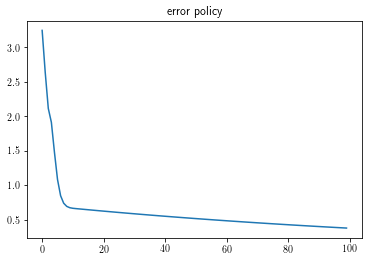

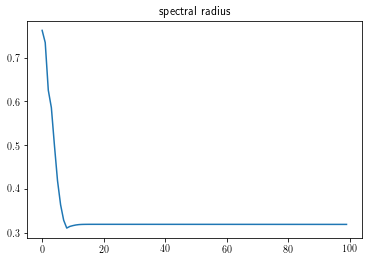

In [7]:
##########################
## CODE BLOCK C
##
## tau-simgrad 
##########################

myseed = seed
mydelta = delta

np.random.seed(myseed)
L0 = L + mydelta*np.random.randn(*L.shape)
K0 = K + mydelta*np.random.randn(*K.shape)
print("seed=",myseed,"delta=",delta)
print("L0=",L0)
print("K0=",L0)

profiles_tau = []
grads_tau = []



X_old = X
MAX_ITER = 100
error = np.zeros((MAX_ITER))*np.nan
error_policy = np.zeros((MAX_ITER))*np.nan
specrad = np.zeros((MAX_ITER))*np.nan
for i in range(MAX_ITER):
    Acl = A-B1@K0 - B2@L0
    specrad[i] = np.max(np.abs(np.linalg.eigvals(Acl)))
    
    # TODO: CHECK IF THE EQUATIONS BELOW ARE CORRECT
    try:
        X0 = SLA.solve_discrete_are(A-B2 @ L0, B1, Q - L0.T @ R2 @ L0, R1)
        W0 = SLA.solve_discrete_are(A-B1 @ K0, B2, -Q - K0.T @ R1 @ K0, R2)
    except LA.LinAlgError:
        print('FAILED to solve DARE at iteration', i ,')\n', 'sp(Acl)=', specrad[i])
        break

    gd_k = 2 * ( R1 @ K0 - B1.T @ (-W0) @ (A-B1@K0 - B2@L0) )
    gd_l = 2 * ( -R2 @ L0 - B2.T @ X0 @ (A-B1@K0 - B2@L0) )
    
    P1 = R1 + B1.T @ (-W0) @ B1 + B1.T @ (-W0) @ B2 @ SLA.inv(R2 - B2.T @ (-W0) @ B2) @ B2.T @ (-W0) @ B1

    ss_k = 0.32/max(abs(LA.eigvals(P1)))
    ss_l = 0.01*ss_k # step size (L)

    # update
    K1 = K0 - ss_k * gd_k
    L1 = L0 + ss_l * gd_l
    error_policy[i] = LA.norm(K0 - K, 'fro') + LA.norm(L0 - L, 'fro')
    profiles_tau.append((K0, L0))
    grads_tau.append((gd_k, gd_l))

    L0 = L1
    K0 = K1
    
plt.title('error policy')
plt.plot(error_policy)
plt.show()
plt.title('spectral radius')
plt.plot(specrad)
plt.show()

seed= 2788441
delta= 0.45
K0= [[ 0.87 -0.1  -0.23  0.   -0.19]
 [ 0.26  0.55 -0.24  0.42 -0.05]]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49

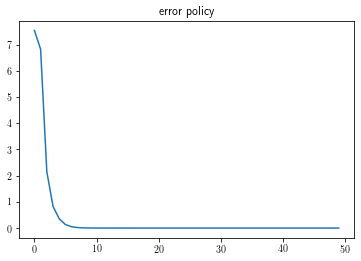

SUCCESS


In [8]:
##########################
## CODE BLOCK D
##
## Natural Gradient for K
##########################

myseed = seed
mydelta = delta
np.random.seed(myseed)
L0 = L + mydelta*np.random.randn(*L.shape)
K0 = K + mydelta*np.random.randn(*K.shape)
print("seed=",myseed)
print("delta=",mydelta)
print("K0=",L0)

X_old = X
MAX_ITER = 50
error = np.zeros((MAX_ITER))
error_policy = np.zeros((MAX_ITER))
for i in range(MAX_ITER):
    stdout.write('\r{}'.format(i))
    W0 = SLA.solve_discrete_are(A-B1 @ K0, B2, -Q - K0.T @ R1 @ K0, R2)
#     
    X0 = -W0
#     print(LA.eigvals(X0-X))
#     error[i] = LA.norm(X0-X)
    error[i] = np.trace( (X0 - X) @ initial_state )
    L0 = -SLA.inv(R2 - B2.T @ X0 @ B2) @ B2.T @ X0 @ (A-B1 @ K0)
    error_policy[i] = LA.norm(L0-L, 'fro') + LA.norm(K0 - K, 'fro')
    # natural gradient
    ngd = 2 * ( R1 @ K0 - B1.T @ X0 @ (A-B1@K0 - B2@L0) )
    # matrix $O_j$; see paper for definition
    P1 = R1 + B1.T @ X0 @ B1 + B1.T @ X0 @ B2 @ SLA.inv(R2 - B2.T @ X0 @ B2) @ B2.T @ X0 @ B1
    # step size
    stepsize = 0.32/max(abs(LA.eigvals(P1)))
    
    # update
    K1 = K0 - stepsize * ngd
    K0 = K1
    
plt.title('error policy')
plt.plot(error_policy)
plt.show()


if np.isclose(error_policy[-1],0):
    print("SUCCESS")

In [9]:
import jax.numpy as jnp
from jax import vmap

e1 = 0.0
e2 = 0.0
noise = 0.1

np.random.seed(0)

from jax import lax
def lyap_iter(A,B,Q,R,N=10):
    def f(P,_):
        return (A.T@P@A - (A.T@P@B)@jnp.linalg.solve(R+B.T@P@B, B.T@P@A) + Q,_)
    return lax.scan(f, Q, jnp.arange(N))[0]

def lyap_dare(A,B,Q,R):
    
    ATinv = jnp.linalg.inv(A).T
    XX = jnp.hstack([A+B@jnp.linalg.solve(R, B.T@jnp.linalg.solve(A.T, Q)), \
                    -B@jnp.linalg.solve(R, B.T@ATinv)])
    YY = jnp.hstack([-jnp.linalg.solve(A.T, Q), ATinv])
    ZZ = jnp.vstack([XX, YY])
    _, UU = jnp.linalg.eig(ZZ)
    U1, U2 = UU[:N,N:], UU[N:,N:]
    P = jnp.linalg.solve(U1.T, U2.T)
    return jnp.real((P+jnp.conj(P).T)/2)
    
def roa(K0, L0, lr1, lr2, N=9):
    def f(K,_):
        K0,L0 = K
        X0 = lyap_dare(A-B2 @ L0, B1, Q - L0.T @ R2 @ L0, R1)
        W0 = lyap_dare(A-B1 @ K0, B2, -Q - K0.T @ R1 @ K0, R2)
        gd_k = 2 * ( R1 @ K0 - B1.T @ (-W0) @ (A-B1@K0 - B2@L0) )
        gd_l = 2 * ( -R2 @ L0 - B2.T @ X0 @ (A-B1@K0 - B2@L0) )
        K1 = K0 + lr1*gd_k
        L1 = L0+lr2*gd_l
        
        return (K1, L1),  jnp.max(jnp.abs(jnp.linalg.eigvals(A-B1@K1-B2@L1)))
    
    return lax.scan(f, (K0, L0), jnp.arange(N))[1][-1]
    

ones = jnp.ones(N)
def specrad(e1, e2, P):
    K = P['K']
    L = P['L']
    Kdir = P['Kdir']
    Ldir = P['Ldir']
    KK = K - e1*Kdir
    LL = L + e2*Ldir
    
    X0 = lyap_dare(A-B1@KK-B2@LL, B, Q-LL.T@R2@LL+KK.T@R1@KK, R)
    cost = np.real(jnp.trace(1/2*(X0+jnp.conj(X0).T)@initial_state))
    
    eigs = jnp.linalg.eigvals(A-B1@KK -B2@LL)
    sp = jnp.max(jnp.abs(eigs))
    controllability =  jnp.linalg.matrix_rank(
        jnp.hstack([((A-B2@LL)**k)@B1 for k in range(N)])) 
    
    #return controllability
    return roa(KK, LL, 0.005, 0.005)
    return cost*(sp<=1)/(sp<=1)
#, sp*(sp<=1)/(sp<=1)

_ = vmap(specrad, (0,None,None))
specradfn = vmap(_, (None,0,None))

lyap_dare(A,B,Q,R)

DeviceArray([[-2.61e+00, -3.12e-03,  4.79e-03, -1.18e-02, -7.60e-03],
             [-3.12e-03, -2.60e+00,  9.63e-03,  2.90e-04, -3.36e-03],
             [ 4.79e-03,  9.63e-03,  2.59e+00, -1.25e-02,  4.17e-03],
             [-1.18e-02,  2.90e-04, -1.25e-02,  2.59e+00, -4.89e-03],
             [-7.60e-03, -3.36e-03,  4.17e-03, -4.89e-03,  2.60e+00]],            dtype=float32)

In [15]:
roa(Kinitial,Linitial,0.005,0.005)

DeviceArray(1.3, dtype=float32)

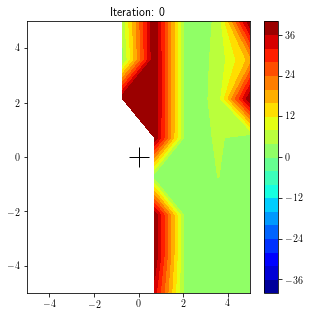

KeyboardInterrupt: 

In [16]:

limax = 40
limin = -40
nlvl = 21
count = 0

cx = 5
cy = 5
linx = jnp.linspace(-cx,cx,8)
liny = jnp.linspace(-cy,cy,8)
XX, YY = np.meshgrid(linx,liny)

for (Kdir,Ldir), (_K,_L) in zip(grads, profiles):
    #scale = np.sqrt(np.linalg.norm(Kdir)**2 + np.linalg.norm(Ldir)**2)
    Kdir = Kdir/np.linalg.norm(Kdir)
    Ldir = Ldir/np.linalg.norm(Ldir)
    P = dict(K=_K, L=_L, Kdir=Kdir, Ldir=Ldir)
    out = specradfn(linx,liny,P)
#    limax = np.maximum(np.abs(np.nanmax(out)), np.abs(np.nanmin(out)))
#    limin = -limax
    out = jnp.maximum(jnp.minimum(out,limax),limin)
    plt.figure(figsize=(5,5))
    img = plt.contourf(XX, YY, out, cmap='jet', levels=np.linspace(limin,limax,nlvl))
    plt.colorbar(img)
    plt.plot(0,0,'+k', ms=20)
    plt.title('Iteration: {}'.format(count))
    plt.savefig('lqr-simgrad-{}.png'.format(count))
    plt.show()
    count += 1

In [ ]:

count = 0
for (Kdir,Ldir), (_K,_L) in zip(grads_tau, profiles_tau):
    Kdir = Kdir/np.linalg.norm(Kdir)
    Ldir = Ldir/np.linalg.norm(Ldir)
    P = dict(K=_K, L=_L, Kdir=Kdir, Ldir=Ldir)
    out = specradfn(linx,liny,P)
    out = jnp.maximum(jnp.minimum(out,limax),limin)
    plt.figure(figsize=(5,5))
    img = plt.contourf(XX, YY, out, cmap='jet', levels=np.linspace(limin,limax,nlvl))
    plt.plot(0,0,'+k', ms=20)
    plt.title('Iteration: {}'.format(count))
    plt.savefig('lqr-tau-simgrad-{:02d}.png'.format(count))
    plt.show()
    count += 1
    if count > 20: break

In [ ]:
!convert -delay 300 -loop 0 lqr-simgrad-0.png -delay 40 lqr-simgrad-*.png -delay 300 lqr-simgrad-9.png lqr-simgrad-leave.gif

In [ ]:
!convert -delay 300 -loop 0 lqr-tau-simgrad-00.png -delay 40 lqr-tau-simgrad-*.png -delay 300 lqr-tau-simgrad-20.png lqr-tau-simgrad-leave.gif

In [ ]:
np.trace(X@initial_state)